# Recomendación de establecimientos comerciales

Un banco desea tener un algoritmo de recomendación de establecimientos comerciales según las características de uso de la tarjeta de débito o crédito de sus clientes. El objetivo es poder predecir la preferencia que tendrá por un determinado establecimiento mediante el coportamiento del uso de su tarjeta.

## Obtención de los datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc

from sklearn.metrics import mean_squared_error
from math import sqrt

DATA_DIR = 'data/'
file_dir = {'transactions': os.path.join(DATA_DIR, '01dataBaseTrainTrxRec.csv'),
            'clients': os.path.join(DATA_DIR, '02dataBasePerfilRec.csv'),
            'test': os.path.join(DATA_DIR, '03dataBaseTestRec.csv'),
            'TestKey': os.path.join(DATA_DIR, '05dataBaseTestKeyRec.csv')}

In [2]:
# Obtención de las tablas
train = pd.read_csv(file_dir['transactions'])
info_clients = pd.read_csv(file_dir['clients'])
testkeys = pd.read_csv(file_dir['TestKey'])

transactions = pd.merge(train, info_clients, on = 'codCliente', how='left')

In [3]:
# Obtenemos todos los keys de los establecimientos y de clientes
frames = [transactions[['codCliente','codEstab']],testkeys]
full = pd.concat(frames)
full.shape

(2058820, 2)

Se están analizando alrededor de dos millones de transacciones

## Comprensión de los datos

In [4]:
transactions.head()

,fechaOper,codCliente,codGiro,codEstab,flagLimaProvEstab,ubigeoEstab,ctdTrx,ratingMonto,rangoEdad,rangoIngreso,...,flagLimaProvCliente,ubigeoCliente,rangoCtdProdAct,rangoCtdProdPas,rangoCtdProdSeg,flagBxi,saldoTcEntidad1,saldoTcEntidad2,saldoTcEntidad3,saldoTcEntidad4
0,2017-01-29 00:00:00,7649,138.0,43629,1,176.0,1,0.014072,Rango4,Rango2,...,1,281.0,Rango1,Rango2,Rango1,1,Rango3,Rango1,Rango1,Rango1
1,2016-12-01 00:00:00,24604,75.0,4326,0,81.0,1,0.001667,Rango2,Rango3,...,0,185.0,Rango1,Rango1,Rango2,1,Rango4,Rango3,Rango1,Rango1
2,2017-06-01 00:00:00,15289,75.0,4326,0,81.0,1,0.000127,Rango3,Rango1,...,0,185.0,Rango1,Rango1,Rango1,1,Rango6,Rango1,Rango1,Rango1
3,2017-09-22 00:00:00,5190,110.0,59776,1,156.0,1,0.001167,Rango5,Rango5,...,1,271.0,Rango2,Rango1,Rango2,1,Rango6,Rango1,Rango1,Rango1
4,2017-05-05 00:00:00,16635,75.0,31043,0,81.0,1,0.047386,Rango5,Rango6,...,0,185.0,Rango1,Rango1,Rango1,1,NaN,NaN,NaN,NaN


Un establecimiento (codEstab) pertenece solamente a un rubro (codGiro), este establecimiento está dentro o fuera Lima (flagLimaProvEstab), el establecimiento se encuentra en un lugar geografico determinado (ubigeoEstab). Cada registro tiene la cantidad de transacciones (ctdTrx) realizada en una fecha determinada (fechaOper) en un establecimiento (codEstab) por un cliente (codCliente). Según la transacción realizada en ese día se la da un rating de acuerdo al monto gastado (ratingMonto).

El propósito del algoritmo es predecir el label ratingMonto mediante el código del cliente y el código del establecimiento

In [5]:
testkeys.head()

,codCliente,codEstab
0,1182,68644
1,1279,789
2,12884,6263
3,1333,899
4,1366,6180


El conjunto de datos está dividido en datos de entrenamiento y de prueba

In [6]:
registros_train = transactions.shape[0]
registros_test = testkeys.shape[0]
registros_total = full.shape[0]

porcentaje_train = round(registros_train/registros_total,2) * 100
porcentaje_test = round(registros_test/registros_total,2) * 100

print("Porcentaje entrenamiento: {}".format(porcentaje_train))
print("Porcentaje prueba: {}".format(porcentaje_test))

# Limpieza de la memoria
del(registros_train,registros_test,registros_total)
del(porcentaje_train,porcentaje_test)
gc.collect()

Porcentaje entrenamiento: 77.0
Porcentaje prueba: 23.0


313

El 77% del conjunto de datos será utilizado para el entrenamiento. El 23% del conjunto de datos para probar el modelo

También se cuenta con información del cliente

In [7]:
info_clients.head()

,codCliente,rangoEdad,rangoIngreso,flagGenero,flagLimaProvCliente,ubigeoCliente,rangoCtdProdAct,rangoCtdProdPas,rangoCtdProdSeg,flagBxi,saldoTcEntidad1,saldoTcEntidad2,saldoTcEntidad3,saldoTcEntidad4
0,24041,Rango2,Rango2,1,0,360.0,Rango1,Rango1,Rango1,1,NaN,NaN,NaN,NaN
1,9040,Rango4,Rango6,1,1,260.0,Rango1,Rango1,Rango1,1,Rango1,Rango1,Rango1,Rango1
2,18233,Rango2,Rango1,1,1,273.0,Rango1,Rango2,Rango1,1,Rango2,Rango1,Rango1,Rango1
3,7226,Rango5,Rango3,0,1,241.0,Rango1,Rango2,Rango1,1,Rango1,Rango2,Rango1,Rango2
4,21617,Rango3,Rango2,1,1,268.0,Rango1,Rango1,Rango1,0,NaN,NaN,NaN,NaN


La tabla de clientes contiene información de la edad (rangoEdad), de los ingresos (rangoIngreso), del género al que pertenece (flagGenero), del lugar de procedencia, si es de afuera o no de Lima, (flagLimaProvCliente), del lugar en que se encuentra el cliente (ubigeoCliente), la cantidad de productos en activos (rangoCtdProdAct) en pasivos(rangoCtdProdPas), en seguros (rangoCtdProdSeg), si está suscrito a banca por internet (flagBxi), el saldo en crédito en cuatro diferentes entidades financieras (saldoTcEntidad).

## Análisis de la variable a predecir

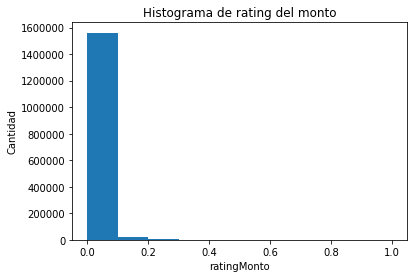

In [8]:
plt.hist(transactions.ratingMonto)
plt.title('Histograma de rating del monto')
plt.xlabel('ratingMonto')
plt.ylabel('Cantidad')
plt.show()

In [9]:
transactions.ratingMonto.describe()

count    1.591617e+06
mean     1.318383e-02
std      3.236438e-02
min      2.984905e-06
25%      1.598366e-03
50%      4.199563e-03
75%      1.152572e-02
max      1.000000e+00
Name: ratingMonto, dtype: float64

Se puede observar que la gran mayoría de los registros tienen un rating de 0.1. Estadísticamente, el conjunto de entrenamiento tiene el 75% de sus datos menor a 0.001152 en rating.

Lo que llama la atención es que existe un registro donde el ratingMonto es 1. Averiguamos cual es este registro

In [10]:
transactions[transactions.ratingMonto == 1]

,fechaOper,codCliente,codGiro,codEstab,flagLimaProvEstab,ubigeoEstab,ctdTrx,ratingMonto,rangoEdad,rangoIngreso,...,flagLimaProvCliente,ubigeoCliente,rangoCtdProdAct,rangoCtdProdPas,rangoCtdProdSeg,flagBxi,saldoTcEntidad1,saldoTcEntidad2,saldoTcEntidad3,saldoTcEntidad4
1395585,2017-07-25 00:00:00,802,114.0,17623,1,175.0,1,1.0,Rango6,Rango1,...,1,270.0,Rango1,Rango2,Rango1,1,Rango1,Rango1,Rango1,Rango1


El registro pertenece al cliente con el código 802. Hay que preguntarse si el cliente ha realizado a otras transacciones

In [11]:
transactions[transactions.codCliente == 802]

,fechaOper,codCliente,codGiro,codEstab,flagLimaProvEstab,ubigeoEstab,ctdTrx,ratingMonto,rangoEdad,rangoIngreso,...,flagLimaProvCliente,ubigeoCliente,rangoCtdProdAct,rangoCtdProdPas,rangoCtdProdSeg,flagBxi,saldoTcEntidad1,saldoTcEntidad2,saldoTcEntidad3,saldoTcEntidad4
1395585,2017-07-25 00:00:00,802,114.0,17623,1,175.0,1,1.0,Rango6,Rango1,...,1,270.0,Rango1,Rango2,Rango1,1,Rango1,Rango1,Rango1,Rango1


El Cliente no ha realizado ninguna otra transacción a parte de la realizada el 25 de febrero de 2017. Al parecer el cliente solamente ha utilizado una vez su tarjeta. Por este hecho el rating monto es 1, ya que el cliente ha realizado todas sus transacciones en un solo establecimiento.

Ahora se analiza las transacciones que tienen un ratingMonto mayor a 0.95

In [12]:
transactions[transactions.ratingMonto > 0.95].head()

,fechaOper,codCliente,codGiro,codEstab,flagLimaProvEstab,ubigeoEstab,ctdTrx,ratingMonto,rangoEdad,rangoIngreso,...,flagLimaProvCliente,ubigeoCliente,rangoCtdProdAct,rangoCtdProdPas,rangoCtdProdSeg,flagBxi,saldoTcEntidad1,saldoTcEntidad2,saldoTcEntidad3,saldoTcEntidad4
342992,2017-06-22 00:00:00,6559,105.0,36,1,157.0,3,0.976620,Rango6,Rango4,...,1,278.0,Rango1,Rango2,Rango2,1,Rango1,Rango1,Rango1,Rango1
657565,2017-04-06 00:00:00,7584,54.0,6454,0,43.0,2,0.972995,Rango5,Rango2,...,0,145.0,Rango1,Rango1,Rango1,0,Rango1,Rango1,Rango1,Rango1
741159,2017-06-23 00:00:00,24720,225.0,6704,1,143.0,1,0.951159,Rango5,Rango1,...,1,283.0,Rango1,Rango1,Rango1,1,Rango1,Rango1,Rango1,Rango1
1395585,2017-07-25 00:00:00,802,114.0,17623,1,175.0,1,1.000000,Rango6,Rango1,...,1,270.0,Rango1,Rango2,Rango1,1,Rango1,Rango1,Rango1,Rango1


Por ejemplo el cliente con el codigo 6559 realizó tres transacciones (ctdTrx) el 22 de Junio (fechaOper) en el establecimiento 36 (codEstab), por lo que obuvo un rating de 0.9766. Esto quiere decir que el 97.66% de lo gastado en ese año mediante su tarjeta lo hizo en la fecha mencionada. Para verificar analizamos las otras transacciones de dicho cliente.

In [13]:
transactions[transactions.codCliente == 6559]

,fechaOper,codCliente,codGiro,codEstab,flagLimaProvEstab,ubigeoEstab,ctdTrx,ratingMonto,rangoEdad,rangoIngreso,...,flagLimaProvCliente,ubigeoCliente,rangoCtdProdAct,rangoCtdProdPas,rangoCtdProdSeg,flagBxi,saldoTcEntidad1,saldoTcEntidad2,saldoTcEntidad3,saldoTcEntidad4
123619,2017-09-08 00:00:00,6559,135.0,24551,1,157.0,1,0.001783,Rango6,Rango4,...,1,278.0,Rango1,Rango2,Rango2,1,Rango1,Rango1,Rango1,Rango1
342992,2017-06-22 00:00:00,6559,105.0,36,1,157.0,3,0.976620,Rango6,Rango4,...,1,278.0,Rango1,Rango2,Rango2,1,Rango1,Rango1,Rango1,Rango1
1141197,2017-02-06 00:00:00,6559,75.0,830,1,157.0,1,0.016247,Rango6,Rango4,...,1,278.0,Rango1,Rango2,Rango2,1,Rango1,Rango1,Rango1,Rango1
1227817,2017-08-08 00:00:00,6559,135.0,24544,1,157.0,1,0.001783,Rango6,Rango4,...,1,278.0,Rango1,Rango2,Rango2,1,Rango1,Rango1,Rango1,Rango1
1331865,2017-10-17 00:00:00,6559,135.0,24551,1,157.0,1,0.001783,Rango6,Rango4,...,1,278.0,Rango1,Rango2,Rango2,1,Rango1,Rango1,Rango1,Rango1


En el conjunto de datos, el cliente 6559 tiene 5 días registrados. En dichos registros, el que mayor ratingMonto tiene es el que tiene mayor cantidad de transacciones (ctdTrx). Los demás registros tienen un ratingMonto más bajo.

Se analiza la relación entre la cantidad de transacciones y el ratingMonto.

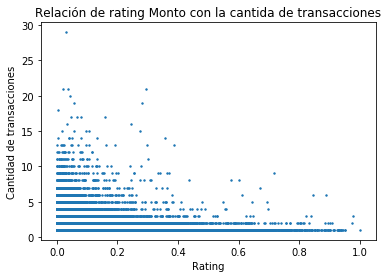

In [25]:
plt.scatter(transactions.ratingMonto,transactions.ctdTrx,2)
plt.title("Relación de rating Monto con la cantida de transacciones")
plt.xlabel("Rating")
plt.ylabel("Cantidad de transacciones")
plt.show()

Según el gráfico a mayor cantidad de transacciones mayor la probabilidad que tenga un ratingMonto menor. En cambio a menor cantidad de transacciones mayor la probabilidad de tener un ratingMonto mayor.

## Análisis de la cantidad de transacciones realizadas por el cliente

Se analiza la cantidad total de transacciones que ha realizado un cliente

In [37]:
tblSimple = transactions[['codCliente','ctdTrx']]
usoCliente = tblSimple.groupby('codCliente', as_index = False).sum()
usoCliente.rename(columns={'ctdTrx':'totCliTrx'}, inplace = True)
transactions_totclitrx = pd.merge(transactions,usoCliente, on = 'codCliente', how='left')
transactions_totclitrx[['totCliTrx','ratingMonto']].corr()

,totCliTrx,ratingMonto
totCliTrx,1.000000,-0.265364
ratingMonto,-0.265364,1.000000


La cantidad total de transacciones que ha realizado el cliente tiene una relación negativa con el ratingMonto.

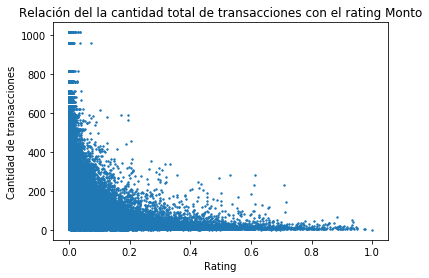

In [40]:
plt.scatter(transactions_totclitrx.ratingMonto,transactions_totclitrx.totCliTrx,2)
plt.title("Relación del la cantidad total de transacciones con el rating Monto")
plt.xlabel("Rating")
plt.ylabel("Cantidad de transacciones")
plt.show()

## Análisis de la cantidad de transacciones realizadas por establecimiento

In [41]:
tblSimple = transactions[['codEstab','ctdTrx']]
usoEstab = tblSimple.groupby('codEstab', as_index = False).sum()
usoEstab.rename(columns={'ctdTrx':'totEstabTrx'}, inplace = True)
transactions_v2 = pd.merge(transactions_totclitrx,usoEstab, on = 'codEstab', how='left')
transactions_v2[['totEstabTrx','ratingMonto']].corr()

,totEstabTrx,ratingMonto
totEstabTrx,1.000000,-0.027619
ratingMonto,-0.027619,1.000000


No existe una relación entre el ratingMonto y la cantidad total de transacciones hechas en un establecimiento

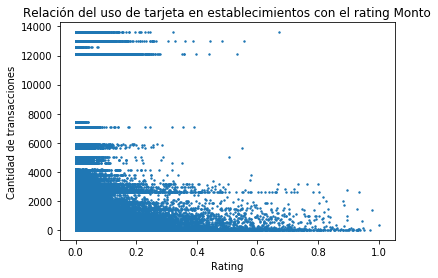

In [43]:
plt.scatter(transactions_v2.ratingMonto,transactions_v2.totEstabTrx,2)
plt.title("Relación del uso de tarjeta en establecimientos con el rating Monto")
plt.xlabel("Rating")
plt.ylabel("Cantidad de transacciones")
plt.show()

## Análisis de la relación entre los clientes y el establecimiento

In [44]:
transactions_v2['prodCliEstab'] = transactions_v2.totCliTrx * transactions_v2.totEstabTrx
transactions_v2[['totCliTrx','totEstabTrx','prodCliEstab','ratingMonto']].corr()

,totCliTrx,totEstabTrx,prodCliEstab,ratingMonto
totCliTrx,1.000000,0.057582,0.349938,-0.265364
totEstabTrx,0.057582,1.000000,0.674479,-0.027619
prodCliEstab,0.349938,0.674479,1.000000,-0.079143
ratingMonto,-0.265364,-0.027619,-0.079143,1.000000


El producto entre el total de las transacciones por el cliente con la cantidad total de transacciones realizadas en los establecimiento no tiene relación con el rating monto.

## Preparación de los datos

## Adquisición de la tabla de establecimientos

In [51]:
def graph_bars(df,titulo,codigo,agg):
    cols_group = [codigo,agg]
    values = df[cols_group].groupby(codigo, as_index = False).sum()
    index = np.arange(values.shape[0])
    plt.bar(index, values[agg])
    plt.xticks(index, values[codigo])
    plt.title(titulo)
    plt.show()

In [77]:
def graph_bars_count(df,titulo,codigo,agg):
    cols_group = [codigo,agg]
    values = df[cols_group].groupby(codigo, as_index = False).count()
    index = np.arange(values.shape[0])
    plt.bar(index, values[agg])
    plt.xticks(index, values[codigo])
    plt.title(titulo)
    plt.show()

In [107]:
# Se obtiene la tabla de establecimientos
establecimientos = transactions[['codEstab','codGiro','ubigeoEstab','flagLimaProvEstab']]
establecimientos = establecimientos.drop_duplicates()
establecimientos.head()

,codEstab,codGiro,ubigeoEstab,flagLimaProvEstab
0,43629,138.0,176.0,1
1,4326,75.0,81.0,0
3,59776,110.0,156.0,1
4,31043,75.0,81.0,0
5,41706,66.0,176.0,1


Se analiza el porcentaje de registros nulos que tiene cada variable

In [108]:
establecimientos.isnull().mean() * 100

codEstab              0.000000
codGiro              25.364882
ubigeoEstab          25.364882
flagLimaProvEstab     0.000000
dtype: float64

Los campos codGiro y ubigeoEstab, al ser códigos provenientes de alguna tabla, puede ser remplazados mediante el valor "0"

In [109]:
establecimientos.codGiro = establecimientos.codGiro.fillna(0)
establecimientos.ubigeoEstab = establecimientos.ubigeoEstab.fillna(0)

Al ser el campo flagLimaProvEstab un valor booleano, debe ser remplazado con "1" o con "0". Para realizar su remplazo se debe optar por aquel valor al cual tienden mas los datos.

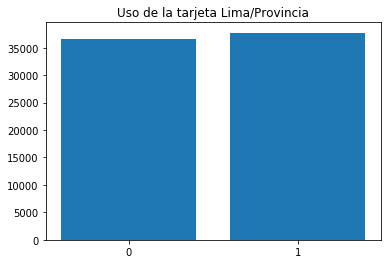

In [119]:
graph_bars_count(establecimientos,'Uso de la tarjeta Lima/Provincia','flagLimaProvEstab','codEstab')

La mayoría de establecimientos tienen el flag 1

In [120]:
# Remplazamos los nulos con el flag 1
establecimientos.flagLimaProvEstab = establecimientos.flagLimaProvEstab.fillna(1)

Se verifica que la tabla de establecimientos no tenga valores nulos

In [122]:
establecimientos.isnull().mean() * 100

codEstab             0.0
codGiro              0.0
ubigeoEstab          0.0
flagLimaProvEstab    0.0
dtype: float64

Se verfica el tipo de datos de la tabla de establecimientos

In [123]:
establecimientos.dtypes

codEstab               int64
codGiro              float64
ubigeoEstab          float64
flagLimaProvEstab      int64
dtype: object

Al ser todos los campos numericos enteros, se cambia a este tipo

In [124]:
establecimientos.flagLimaProvEstab = establecimientos.flagLimaProvEstab.astype('int', inplace = True)
establecimientos.ubigeoEstab = establecimientos.ubigeoEstab.astype('int', inplace = True)
establecimientos.codGiro = establecimientos.codGiro.astype('int', inplace = True)

In [125]:
establecimientos.head()

,codEstab,codGiro,ubigeoEstab,flagLimaProvEstab
0,43629,138,176,1
1,4326,75,81,0
3,59776,110,156,1
4,31043,75,81,0
5,41706,66,176,1


## Creación de la tabla de clientes

In [69]:
info_clients.head()
clients = info_clients
clients.head()

,codCliente,rangoEdad,rangoIngreso,flagGenero,flagLimaProvCliente,ubigeoCliente,rangoCtdProdAct,rangoCtdProdPas,rangoCtdProdSeg,flagBxi,saldoTcEntidad1,saldoTcEntidad2,saldoTcEntidad3,saldoTcEntidad4
0,24041,Rango2,Rango2,1,0,360.0,Rango1,Rango1,Rango1,1,NaN,NaN,NaN,NaN
1,9040,Rango4,Rango6,1,1,260.0,Rango1,Rango1,Rango1,1,Rango1,Rango1,Rango1,Rango1
2,18233,Rango2,Rango1,1,1,273.0,Rango1,Rango2,Rango1,1,Rango2,Rango1,Rango1,Rango1
3,7226,Rango5,Rango3,0,1,241.0,Rango1,Rango2,Rango1,1,Rango1,Rango2,Rango1,Rango2
4,21617,Rango3,Rango2,1,1,268.0,Rango1,Rango1,Rango1,0,NaN,NaN,NaN,NaN


Se analiza la cantidad de nulos

In [70]:
clients.isnull().mean() * 100

codCliente              0.000000
rangoEdad               0.190000
rangoIngreso            4.210000
flagGenero              0.000000
flagLimaProvCliente     0.000000
ubigeoCliente           0.013333
rangoCtdProdAct         0.000000
rangoCtdProdPas         0.000000
rangoCtdProdSeg         0.000000
flagBxi                 0.000000
saldoTcEntidad1        21.420000
saldoTcEntidad2        21.420000
saldoTcEntidad3        21.420000
saldoTcEntidad4        21.420000
dtype: float64

In [72]:
# Remplazamos el valor faltante del codigo de ubigeoCliente
clients.ubigeoCliente = clients.ubigeoCliente.fillna(0)

Se analiza los rangos de edad

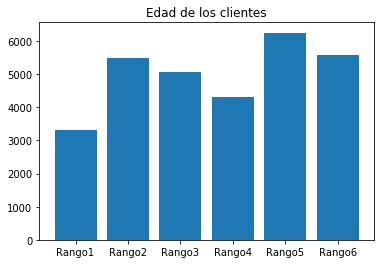

In [85]:
graph_bars_count(clients,"Edad de los clientes",'rangoEdad','codCliente')

In [88]:
# Se remplaza los valores faltantes de rangoEdad con el Rango5
clients.rangoEdad = clients.rangoEdad.fillna('Rango5')

Se analiza los rangos de ingresos

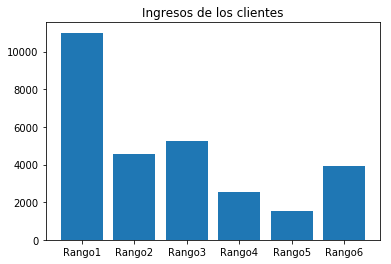

In [86]:
graph_bars_count(clients,"Ingresos de los clientes",'rangoIngreso','codCliente')

In [89]:
# Se remplaza los valores faltantes de rangoEdad con el Rango1
clients.rangoIngreso = clients.rangoIngreso.fillna('Rango1')

Debido al gran porcentaje de datos nulos en los rangos de tarjetas de créditos de otras entidades financieras se eliminan dichas columnas (saldoTcEntidad1,saldoTcEntidad2,saldoTcEntidad3,saldoTcEntidad4)

In [92]:
clients = clients.drop(['saldoTcEntidad1','saldoTcEntidad2','saldoTcEntidad3','saldoTcEntidad4'], axis = 1)

In [94]:
clients.isnull().mean() * 100

codCliente             0.0
rangoEdad              0.0
rangoIngreso           0.0
flagGenero             0.0
flagLimaProvCliente    0.0
ubigeoCliente          0.0
rangoCtdProdAct        0.0
rangoCtdProdPas        0.0
rangoCtdProdSeg        0.0
flagBxi                0.0
dtype: float64

In [95]:
clients.dtypes

codCliente               int64
rangoEdad               object
rangoIngreso            object
flagGenero               int64
flagLimaProvCliente      int64
ubigeoCliente          float64
rangoCtdProdAct         object
rangoCtdProdPas         object
rangoCtdProdSeg         object
flagBxi                  int64
dtype: object

In [96]:
clients.ubigeoCliente = clients.ubigeoCliente.astype('int', inplace = True)

In [98]:
clients.head()

,codCliente,rangoEdad,rangoIngreso,flagGenero,flagLimaProvCliente,ubigeoCliente,rangoCtdProdAct,rangoCtdProdPas,rangoCtdProdSeg,flagBxi
0,24041,Rango2,Rango2,1,0,360,Rango1,Rango1,Rango1,1
1,9040,Rango4,Rango6,1,1,260,Rango1,Rango1,Rango1,1
2,18233,Rango2,Rango1,1,1,273,Rango1,Rango2,Rango1,1
3,7226,Rango5,Rango3,0,1,241,Rango1,Rango2,Rango1,1
4,21617,Rango3,Rango2,1,1,268,Rango1,Rango1,Rango1,0


## Obtención de la cantidad de transacciones

In [128]:
def getTrx(tbl_agg, codigo,nombre_trx):
    df = tbl_agg[[codigo,'ctdTrx']]
    df = df.groupby(codigo, as_index = False).sum()
    df.rename(columns={'ctdTrx':nombre_trx}, inplace = True)
    return df

In [127]:
def merge_trx(tbl_agg, tbl_merge, lista_vars):
    for var in lista_vars:
        codigo = var[0]
        trx = var[1]
        tbl_merge = pd.merge(tbl_merge, getTrx(tbl_agg, codigo,trx), on=codigo, how='left')
        
        # Se remplaza los nulos con la media
        media_col = tbl_merge[trx].mean()
        tbl_merge[trx] = tbl_merge[trx].fillna(media_col)
    
    return tbl_merge

Se obtienen la cantidad de transacciones de los clientes y las ubicaciones gegráficas de los clientes

In [154]:
lista_vars = [
    ['codCliente','trxCliente'],
    ['ubigeoCliente','trxGeoCliente'],
]

clients_trx = merge_trx(transactions,clients,lista_vars)
clients_trx.head()

,codCliente,rangoEdad,rangoIngreso,flagGenero,flagLimaProvCliente,ubigeoCliente,rangoCtdProdAct,rangoCtdProdPas,rangoCtdProdSeg,flagBxi,trxCliente,trxGeoCliente
0,24041,Rango2,Rango2,1,0,360,Rango1,Rango1,Rango1,1,4,4.0
1,9040,Rango4,Rango6,1,1,260,Rango1,Rango1,Rango1,1,77,36193.0
2,18233,Rango2,Rango1,1,1,273,Rango1,Rango2,Rango1,1,65,29861.0
3,7226,Rango5,Rango3,0,1,241,Rango1,Rango2,Rango1,1,366,52562.0
4,21617,Rango3,Rango2,1,1,268,Rango1,Rango1,Rango1,0,15,18641.0


In [138]:
clients_trx.isnull().mean()

codCliente             0.0
rangoEdad              0.0
rangoIngreso           0.0
flagGenero             0.0
flagLimaProvCliente    0.0
ubigeoCliente          0.0
rangoCtdProdAct        0.0
rangoCtdProdPas        0.0
rangoCtdProdSeg        0.0
flagBxi                0.0
trxCliente             0.0
trxGeoCliente          0.0
dtype: float64

Se obtienen la cantidad de transacciones de los establecimientos, los rubros (giros) y la ubicación geográfica de los mismos

In [141]:
lista_vars = [
    ['codGiro','trxGiro'],
    ['ubigeoEstab','trxUbigeoEstab'],
    ['codEstab','trxEstab']
]

estab_trx = merge_trx(transactions,establecimientos,lista_vars)
estab_trx.head()

,codEstab,codGiro,ubigeoEstab,flagLimaProvEstab,trxGiro,trxUbigeoEstab,trxEstab
0,43629,138,176,1,119.0,40121.0,1
1,4326,75,81,0,345939.0,38187.0,1085
2,59776,110,156,1,243278.0,22634.0,165
3,31043,75,81,0,345939.0,38187.0,1339
4,41706,66,176,1,1822.0,40121.0,1


In [143]:
estab_trx.isnull().mean()

codEstab             0.0
codGiro              0.0
ubigeoEstab          0.0
flagLimaProvEstab    0.0
trxGiro              0.0
trxUbigeoEstab       0.0
trxEstab             0.0
dtype: float64

## Obtención del conjunto de entrenamiento y prueba

In [170]:
train = transactions[['codCliente','codEstab','ratingMonto']]
train = pd.merge(train, clients_trx, on='codCliente', how = 'left')
train = pd.merge(train, estab_trx, on='codEstab', how = 'left')
train.head()

,codCliente,codEstab,ratingMonto,rangoEdad,rangoIngreso,flagGenero,flagLimaProvCliente,ubigeoCliente,rangoCtdProdAct,rangoCtdProdPas,rangoCtdProdSeg,flagBxi,trxCliente,trxGeoCliente,codGiro,ubigeoEstab,flagLimaProvEstab,trxGiro,trxUbigeoEstab,trxEstab
0,7649,43629,0.014072,Rango4,Rango2,1,1,281,Rango1,Rango2,Rango1,1,252,32634.0,138,176,1,119.0,40121.0,1
1,24604,4326,0.001667,Rango2,Rango3,1,0,185,Rango1,Rango1,Rango2,1,177,31324.0,75,81,0,345939.0,38187.0,1085
2,15289,4326,0.000127,Rango3,Rango1,0,0,185,Rango1,Rango1,Rango1,1,27,31324.0,75,81,0,345939.0,38187.0,1085
3,5190,59776,0.001167,Rango5,Rango5,0,1,271,Rango2,Rango1,Rango2,1,210,70720.0,110,156,1,243278.0,22634.0,165
4,16635,31043,0.047386,Rango5,Rango6,1,0,185,Rango1,Rango1,Rango1,1,12,31324.0,75,81,0,345939.0,38187.0,1339


In [171]:
trx_vars = ['trxCliente','trxGeoCliente','trxGiro','trxUbigeoEstab','trxEstab','ratingMonto']
train[trx_vars].corr()

,trxCliente,trxGeoCliente,trxGiro,trxUbigeoEstab,trxEstab,ratingMonto
trxCliente,1.000000,0.280833,0.021367,0.233382,0.057582,-0.265364
trxGeoCliente,0.280833,1.000000,0.017629,0.380558,0.049382,-0.106287
trxGiro,0.021367,0.017629,1.000000,-0.037253,0.042918,-0.116423
trxUbigeoEstab,0.233382,0.380558,-0.037253,1.000000,0.301125,-0.074534
trxEstab,0.057582,0.049382,0.042918,0.301125,1.000000,-0.027619
ratingMonto,-0.265364,-0.106287,-0.116423,-0.074534,-0.027619,1.000000


In [172]:
train = pd.get_dummies(train, 
               prefix=['Edad', 'Ingreso', 'Act', 'Pas', 'Seg'], 
               columns=['rangoEdad', 'rangoIngreso', 'rangoCtdProdAct', 
                        'rangoCtdProdPas', 'rangoCtdProdSeg'])

In [173]:
# Se elimina las columnas categoricas
train = train.drop(['codGiro','ubigeoEstab','ubigeoCliente'], axis = 1)

In [176]:
train.shape

(1591617, 34)

## Modelado del conjunto de datos

In [181]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from time import time

In [184]:
# Get train data
trainV1 = train.copy()

# split data into X and y
X = trainV1.drop('ratingMonto', axis=1)
Y = trainV1['ratingMonto']
# split data into train and test sets
features_train, features_test, label_train, label_test = train_test_split(X, Y, test_size = 0.3)

# training model
model = xgb.XGBRegressor(
    learning_rate =0.2,
    max_depth=5,
    n_estimators=200,
    seed=123)
t0 = time()
model.fit(features_train, label_train)
print ("training time:", round(time()-t0, 3), "s")

# testing model
t0 = time()
label_pred = model.predict(features_test)
print ("Predicting time:", round(time()-t0, 3), "s")

# accuracy
acc = sqrt(mean_squared_error(label_test, label_pred))
print ("RMSE:", round(acc, 6))

training time: 418.876 s
Predicting time: 4.364 s
RMSE: 0.026204


In [186]:
from sklearn.linear_model import LinearRegression

trainV1 = train.copy()

# split data into X and y
X = trainV1.drop('ratingMonto', axis=1)
Y = trainV1['ratingMonto']

# split data into train and test sets
features_train, features_test, label_train, label_test = train_test_split(X, Y, test_size = 0.3)

# training model
t0 = time()
model = LinearRegression(normalize = True, n_jobs = 5)
model = model.fit(features_train, label_train)
print ("training time:", round(time()-t0, 3), "s")

# testing model
t0 = time()
label_pred = model.predict(features_test)
print ("Predicting time:", round(time()-t0, 3), "s")

# accuracy
acc = sqrt(mean_squared_error(label_test, label_pred))
print ("RMSE:", round(acc, 6))

training time: 2.416 s
Predicting time: 0.14 s
RMSE: 0.031009
